See: https://valentinaalto.medium.com/introducing-agent-based-rag-9b7141ae1cd7

In [1]:
import sqlite3
import pandas as pd

# Sample data from the CSV
data = {
    "Name": ["John Doe", "Jane Smith", "Alex Johnson", "Chris Lee", "Patricia Brown"],
    "Gender": ["Male", "Female", "Male", "Non-binary", "Female"],
    "Age": [28, 34, 22, 29, 41],
    "Previous Purchases": [
        "Pro Gear 123 Climbing Shoes, UltraClip Carabiner, StrongRope 500",
        "ClimbSafe Harness, GripMaster Chalk Bag, RockShield Helmet",
        "QuickClip Carabiner",
        "SummitX Climbing Shoes, ClimbSafe Harness",
        "StrongRope 500, ProGrip Chalk, SecureBelay Device, QuickLink Quickdraw Set"
    ],
    "Reviews Given": [
        "I really liked this product!",
        "The product quality is great, highly recommend!",
        "It's okay, but I expected better.",
        "Good value for the price.",
        "Excellent gear, will buy again!"
    ]
}

DATABASE_NAME="climbing_gear_customers.sql"

# Converting the dictionary to a DataFrame
df = pd.DataFrame(data)

# Connecting to a SQLite database (it will create a new one if it doesn't exist)
conn = sqlite3.connect(DATABASE_NAME)

# Storing the DataFrame in the SQLite database
df.to_sql('customer_interactions', conn, index=False, if_exists='replace')

# Committing and closing the connection
conn.commit()
conn.close()

In [2]:
import sys 
sys.path.append(r'C:\Users\ELAFACRB1\Codice\GitHub\rio-utils-app\src')
sys.path.append(r'..')
from utils.text_processing import TextSplitter
from utils.embedding import EmbeddingFunction
from utils.database_managers import QDrantDBManager
import os

QDRANT_URL=os.getenv('QDRANT_URL')
COLLECTION_NAME="climbing-gear-customers"

embedding = EmbeddingFunction('fast-bgeEmbedding').embedder
text_splitter = TextSplitter(
    chunk_size=2000, 
    chunk_overlap=20
)

qdrantClient = QDrantDBManager(
    url=QDRANT_URL,
    port=6333,
    collection_name=COLLECTION_NAME,
    vector_size=768,
    embedding=embedding,
    record_manager_url="sqlite:///record_manager_cache.sql"
)
retriever=qdrantClient.vector_store.as_retriever()


c:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\venv\chatbot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-30 11:41:26.993 | ERROR    | fastembed.common.model_management:download_model:236 - Could not download model from HuggingFace: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/models/qdrant/bge-base-en-v1.5-onnx-q/revision/main (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))"), '(Request ID: 5a749d02-d173-44a7-a759-e3613dc4efc9)')Falling back to other sources.


Collection climbing-gear-customers already exists!


c:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\venv\chatbot\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 0.3.0. An updated version of the class exists in the langchain-qdrant package and should be used instead. To use it run `pip install -U langchain-qdrant` and import as `from langchain_qdrant import Qdrant`.
  warn_deprecated(


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain.document_loaders import PyPDFDirectoryLoader

file_path = (
    r"C:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\test\Climbing product sheet.pdf"
)
loader = PyPDFLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

qdrantClient.vector_store.add_documents(documents=docs)

file_path = (
    r"C:\Users\ELAFACRB1\Codice\GitHub\langgraph-rag-chatbot\test\trekkings"
)
loader = PyPDFDirectoryLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [9]:
import sqlite3
import pandas as pd
# from utils import langgraph
# from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_function
from typing import Dict, TypedDict, Optional
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import END, StateGraph
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
import operator
import functools
from dotenv import load_dotenv
load_dotenv(override=True)
import sys 
sys.path.append(r'..')
import os
import json 
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from typing import Literal
from tools.sql import toolkit
from tools.rag import trekking_tool
from utils.text_processing import TextSplitter
from utils.embedding import EmbeddingFunction
from utils.database_managers import QDrantDBManager
import os

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 7256.58it/s]


Collection climbing-gear-customers already exists!


In [6]:
toolkit.get_tools()

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000013CAD07DF10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000013CAD07DF10>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000013CAD07DF10>),
 QuerySQLCheckerTool(description='Use this tool to 

In [10]:
tools = [trekking_tool, toolkit.get_tools()[0], toolkit.get_tools()[1], toolkit.get_tools()[2], toolkit.get_tools()[3]]

# Building the Graph

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from graph.nodes import Assistant, assistant_runnable
from graph.state import create_tool_node_with_fallback, State

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

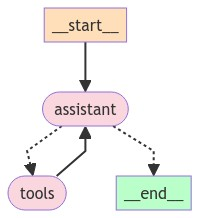

In [14]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [16]:
import shutil
import uuid

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [ ]:
question = "Hi there, Can you help me find some climbing shoes based on my previous purchases?"

In [18]:
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "name": "John Doe",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()

events = part_1_graph.stream(
    {"messages": ("user", question)}, 
    config, 
    stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

Hi there, Can you help me find some climbing shoes based on my previous purchases?
================================== Ai Message ==================================
Tool Calls:
  trekking_search (call_t2gy)
 Call ID: call_t2gy
  Args:
    query: John Doe
================================= Tool Message =================================
Name: trekking_search

o Available Sizes:  5-12 (US)  
o Colors: Yellow, Black  
9. ProGrip Chalk  
• Category:  Accessories  
• Description:  ProGrip Chalk is a premium chalk blend that provides superior grip and 
moisture absorption, essential for climbing in humid or sweaty conditions. It comes in a 
resealable bag, ensuring the chalk remains dry and ready to use. Suitable for all types of 
climbing, from bouldering to high -altitude ascents.  
• Specifications:  
o Material:  Magnesium carbonate  
o Weight: 100 grams, 200 grams  
o Packaging:  Resealable bag  
o Additional